# Analysis of Kaggle's Heart Failure dataset

Required libraries for data wrangling, statistical analysis and plotting. ~~Plotnine was chosen for similarity to ggplot2 in R.~~ As Plotnine does not have a pairplot API for fast pairwise comparison, I'll switch to Seaborn.

In [361]:
import numpy as np
import pandas as pd
#from plotnine import *
import seaborn as sb

## Data loading, inspection and curation
First, load the heart failure dataset supplied by Kaggle and perform some basic introspection on the overall shape of the data and the type of features it contains.

In [362]:
df = pd.read_csv('heart.csv')
print(df.shape)
print(df.dtypes)
df.head()
#sb.pairplot(df, hue="HeartDisease", corner=True)

(918, 12)
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


This learns us that there are a total of 918 rows and 12 features. Several features have object datatype, but I would prefer category datatype. So for those features I'll check whether the number of distinct objects per feature is small. HeartDisease could be transformed to a boolean, perhaps ExerciseAngina nad FastingBS as well.

In [363]:
for col in df[["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina"]]:
    print(col, df[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']


Above suspicions are confirmed; the respective features have few distinct values each and some can be turned to a boolean. Below the colums are assigned their new data types and a check is done afterwards to assure the conversion was done correctly, such that every feature retains all of its values.

In [364]:
# Convert to category
for col in df[["Sex","ChestPainType","RestingECG"]]:
    df[col] = df[col].astype('category')
# Convert to boolean
for col in df[["FastingBS","HeartDisease"]]:
    df[col] = df[col].astype('bool')
df["ExerciseAngina"] = df['ExerciseAngina'].replace({'N': 0, 'Y': 1})
df["ExerciseAngina"] = df["ExerciseAngina"].astype('bool')
print(df.dtypes)
for col in df[["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","HeartDisease"]]:
    print(col, df[col].unique())

Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS             bool
RestingECG        category
MaxHR                int64
ExerciseAngina        bool
Oldpeak            float64
ST_Slope            object
HeartDisease          bool
dtype: object
Sex ['M', 'F']
Categories (2, object): ['F', 'M']
ChestPainType ['ATA', 'NAP', 'ASY', 'TA']
Categories (4, object): ['ASY', 'ATA', 'NAP', 'TA']
FastingBS [False  True]
RestingECG ['Normal', 'ST', 'LVH']
Categories (3, object): ['LVH', 'Normal', 'ST']
ExerciseAngina [False  True]
HeartDisease [False  True]


## Explorative analysis

There are a variety of interesting feature combinations for an initial explorative analysis, to give some insight on general feature value distributions and correlations.

In [365]:
# Add binned 5y range age for later
cut_bins = []
cut_labels = []
for i in range(0,20):
    cut_bins.append(i*5)
    cut_labels.append(str((i*5)-5)+"-"+str(i*5))
cut_labels.remove("-5-0") # nr of labels should be bins-1
df["Bin_Age"] = pd.cut(df["Age"], bins=cut_bins, labels=cut_labels)
df["Bin_Age"] = df["Bin_Age"].astype("category")

# Distribution of HD per Sex, as counts and percentage of total nr of people
df_dist = (
    df.groupby('Sex', as_index=True)
        .agg(HeartDisease=('HeartDisease', 'sum'),
             Nr_of_people=('HeartDisease', 'count'),
             HD_pct=('HeartDisease', 'mean'))
)
df_dist["HD_pct"] *= 100
print(df_dist)

     HeartDisease  Nr_of_people     HD_pct
Sex                                       
F              50           193  25.906736
M             458           725  63.172414


--

C:\Users\tch\AppData\Local\Temp/ipykernel_7652/3085644369.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


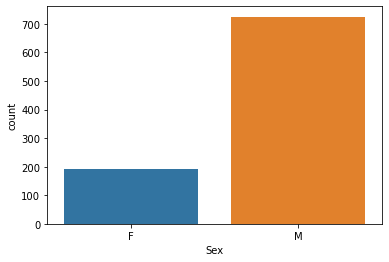

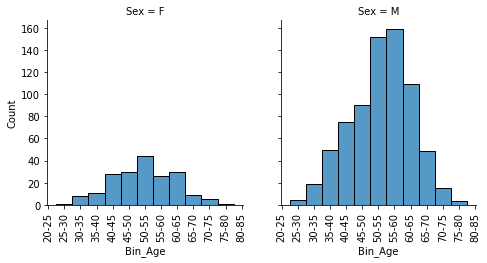

In [366]:
# Count Male vs Female
sb.countplot(x="Sex",data=df)

# Plot distribution of Male/Female to Age, with median age
g = sb.FacetGrid(df, col="Sex", height=3.5, aspect=1)
g.map(sb.histplot, "Bin_Age")
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

--

In [367]:
# sb.pairplot(df, hue="HeartDisease", corner=True,
# vars = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"],
# plot_kws={"alpha":0.4})


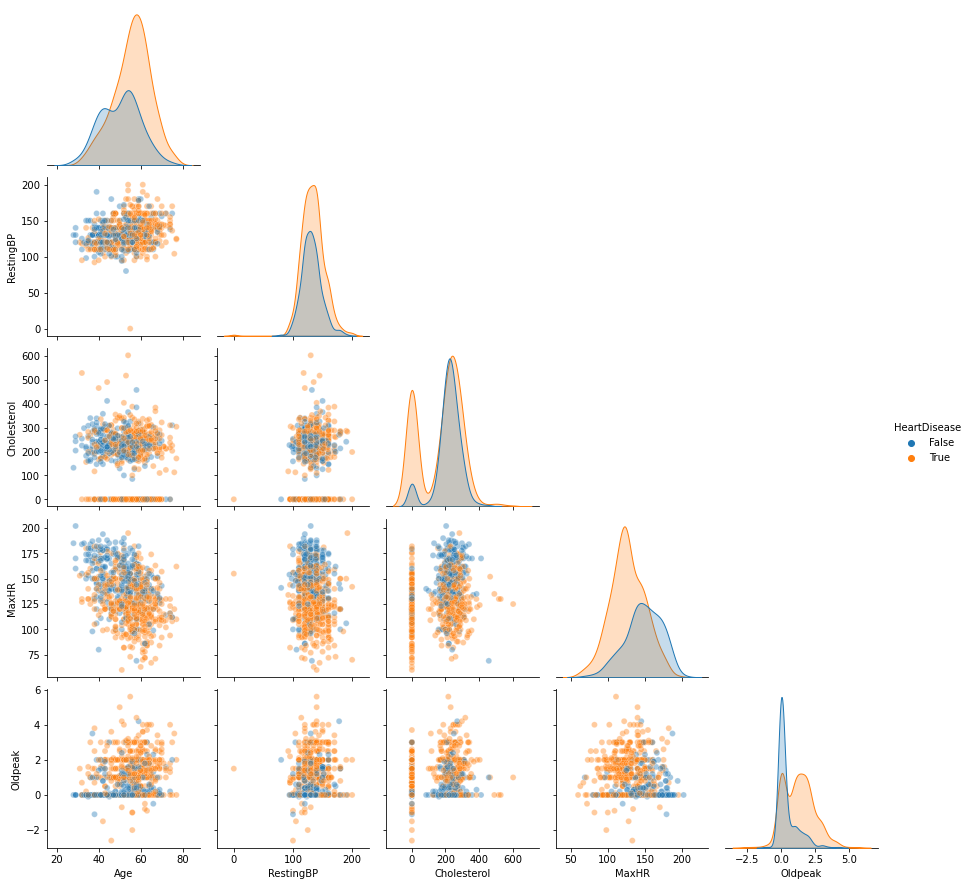

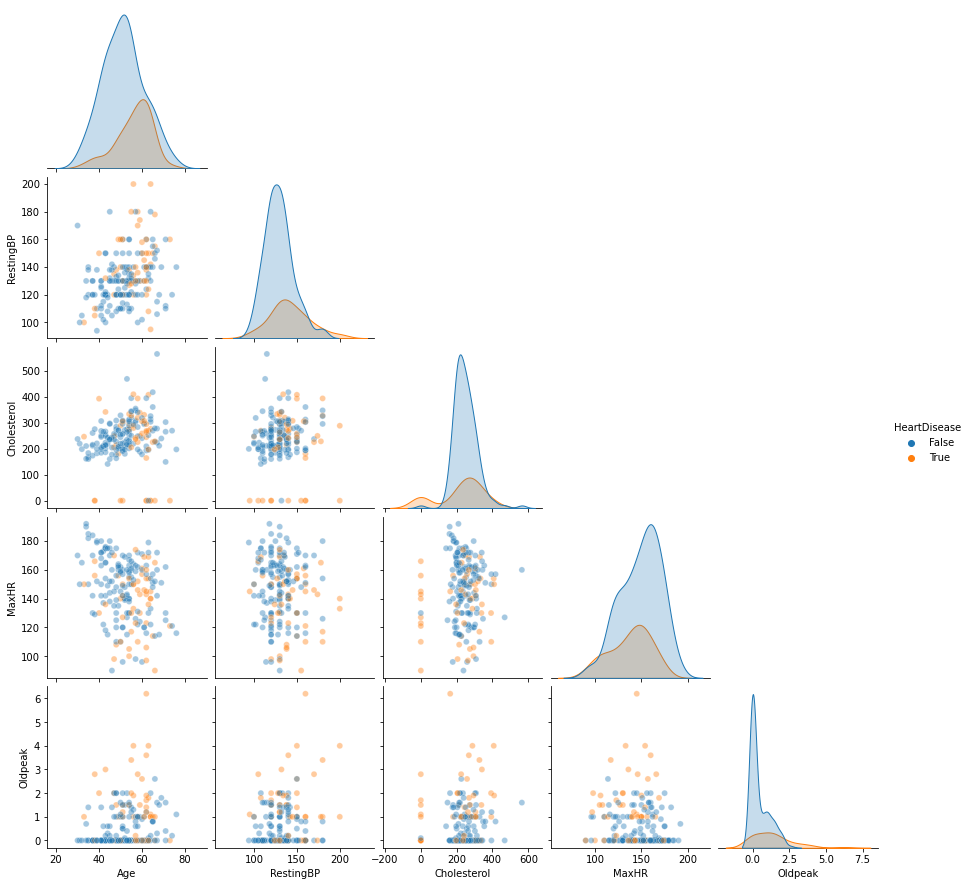

In [368]:
df_m = df.loc[df["Sex"] == "M"]
df_f = df.loc[df["Sex"] == "F"]
for df_x in [df_m,df_f]:
    sb.pairplot(df_x, hue="HeartDisease", corner=True,
    vars = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"],
    plot_kws={"alpha":0.4})

## To-Do:
## - pca for detection of max variance
## - clustering on features
## - trees / random forest
## - log. regression
## - Pytorch NN